In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for i, filename in enumerate(filenames):
        if i < 3:
            print(os.path.join(dirname, filename))

/kaggle/input/emotion-predict-spectograms/train_data.csv
/kaggle/input/emotion-predict-spectograms/test_data.csv
/kaggle/input/emotion-predict-spectograms/TestImages/12751.mp3.png
/kaggle/input/emotion-predict-spectograms/TestImages/22208.mp3.png
/kaggle/input/emotion-predict-spectograms/TestImages/16566.mp3.png
/kaggle/input/emotion-predict-spectograms/TrainImages/4321.mp3.png
/kaggle/input/emotion-predict-spectograms/TrainImages/7306.mp3.png
/kaggle/input/emotion-predict-spectograms/TrainImages/1196.mp3.png
/kaggle/input/audio-emotion-pred-melspect/pretrain_data.csv
/kaggle/input/audio-emotion-pred-melspect/PretrainImages/YAF_sure_happy.wav.png
/kaggle/input/audio-emotion-pred-melspect/PretrainImages/1069_TAI_DIS_XX.wav.png
/kaggle/input/audio-emotion-pred-melspect/PretrainImages/1033_IEO_DIS_LO.wav.png


In [2]:
pretrain_csv = "/kaggle/input/audio-emotion-pred-melspect/pretrain_data.csv"
pretrain_df = pd.read_csv(pretrain_csv)
pretrain_df.shape, pretrain_df.columns, pretrain_df['emotion'].value_counts()

((12798, 2),
 Index(['filename', 'emotion'], dtype='object'),
 anger       2167
 sadness     2167
 joy         2167
 fear        2047
 disgust     1863
 neutral     1795
 surprise     592
 Name: emotion, dtype: int64)

In [3]:
pretrain_fp = "/kaggle/input/audio-emotion-pred-melspect/PretrainImages/"

In [4]:
from fastai.vision import *
from fastai.vision.all import *

pretrain_dl = ImageDataLoaders.from_df(pretrain_df, pretrain_fp, valid_pct=0.2,
                               item_tfms=[Resize(144)],
                               batch_tfms=aug_transforms(),
                                       num_workers=1)
len(pretrain_dl.train_ds.items), len(pretrain_dl.valid_ds.items), pretrain_dl.c

(10239, 2559, 7)

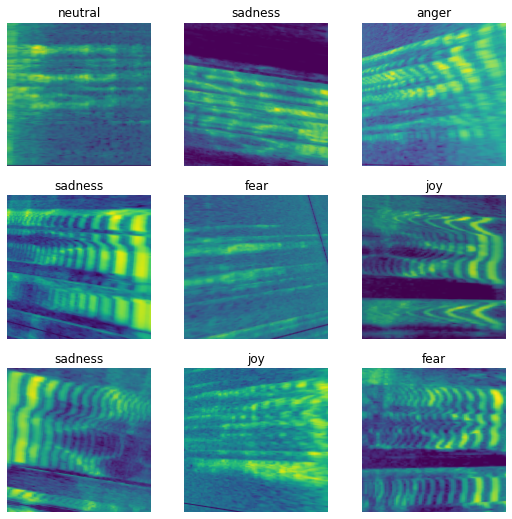

In [5]:
pretrain_dl.show_batch()

In [6]:
model = xresnet50(n_out=pretrain_dl.c)

In [7]:
learn = Learner(pretrain_dl, model, 
                metrics=accuracy,
                # pretrained=True, 
                path=".",
                model_dir="/kaggle/working/models")

In [8]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3, 3e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.661356,2.187269,0.245018,01:49
1,1.554349,1.939483,0.302462,01:16
2,1.439904,1.511866,0.381790,01:17
3,1.294777,1.284687,0.490035,01:16
4,1.215297,1.180020,0.531458,01:16
5,1.115346,1.307660,0.512700,01:16
6,1.042448,1.067304,0.579523,01:17
7,0.978090,0.987468,0.606487,01:16
8,0.939163,0.987280,0.616256,01:16
9,0.902091,0.988185,0.615084,01:16


In [9]:
learn.freeze()
learn.fit_one_cycle(5, slice(1e-6,1e-4))
learn.fine_tune(5, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,time
0,0.915716,0.978094,0.618601,01:17
1,0.900398,0.970366,0.620946,01:15
2,0.891774,0.974643,0.620164,01:23
3,0.888747,0.964475,0.624072,01:15
4,0.880336,0.966830,0.627589,01:15


epoch,train_loss,valid_loss,accuracy,time
0,0.918006,1.003780,0.611567,01:16
1,0.978193,1.062803,0.586557,01:15
2,1.015869,1.058951,0.586948,01:15


epoch,train_loss,valid_loss,accuracy,time
0,0.911597,0.961268,0.614302,01:16
1,0.934638,1.054186,0.591637,01:16
2,0.884295,0.985125,0.613521,01:22
3,0.844328,0.931297,0.638531,01:17
4,0.789873,0.922575,0.644392,01:16


In [10]:
learn.save("pretrained")

Path('/kaggle/working/models/pretrained.pth')

In [11]:
train_csv = "/kaggle/input/emotion-predict-spectograms/train_data.csv"
test_csv = "/kaggle/input/emotion-predict-spectograms/test_data.csv"

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)
train_df.shape, test_df.shape

((5816, 2), (2492, 2))

In [12]:
TRAIN_fp = "/kaggle/input/emotion-predict-spectograms/TrainImages/"
TEST_fp = "/kaggle/input/emotion-predict-spectograms/TestImages/"

train_files = [fn for fn in os.listdir(TRAIN_fp) if fn.split('.')[-1] in ['png']]
test_files = [fn for fn in os.listdir(TEST_fp) if fn.split('.')[-1] in ['png']]
len(train_files), len(test_files)

(5816, 2492)

In [13]:
dls = ImageDataLoaders.from_df(train_df, TRAIN_fp, valid_pct=0.1,
                               item_tfms=[Resize(144)],
                               batch_tfms=aug_transforms(),
                              num_workers=2)
len(dls.train_ds.items), len(dls.valid_ds.items), dls.c

(5235, 581, 7)

In [14]:
learn = Learner(dls, model, 
                metrics=accuracy,
                # pretrained=True, 
                path=".",
                model_dir="/kaggle/working/models")

In [15]:
learn.load("pretrained")

In [16]:
learn.fine_tune(10, freeze_epochs=5)

epoch,train_loss,valid_loss,accuracy,time
0,2.284264,1.699721,0.406196,00:34
1,1.604540,1.418492,0.516351,00:28
2,1.422037,1.412155,0.473322,00:28
3,1.380990,1.357722,0.538726,00:28
4,1.347008,1.371606,0.512909,00:28


epoch,train_loss,valid_loss,accuracy,time
0,1.283081,1.312529,0.537005,00:28
1,1.278600,1.283170,0.564544,00:28
2,1.293702,1.315764,0.549053,00:28
3,1.280309,1.312669,0.540448,00:29
4,1.259706,1.368149,0.519793,00:29
5,1.240241,1.323395,0.545611,00:30
6,1.212227,1.354839,0.493976,00:28
7,1.175822,1.347723,0.516351,00:28
8,1.154155,1.364360,0.492255,00:28
9,1.119447,1.357348,0.497418,00:28


In [17]:
learn.freeze()
learn.fit_one_cycle(5, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.131151,1.364782,0.480207,00:28
1,1.117832,1.373437,0.490534,00:28
2,1.121631,1.376353,0.506024,00:28
3,1.114369,1.380593,0.499139,00:28
4,1.108204,1.372498,0.502582,00:28


In [18]:
fnames = get_image_files(TEST_fp)
dl = learn.dls.test_dl(fnames, bs=64) # apply transforms
preds,  _ = learn.get_preds(dl=dl) # get prediction

In [19]:
labels = learn.dls.vocab

test_data = []
for fn, pred in zip(fnames, preds):
    idx = torch.argmax(pred).numpy()
    fr = str(fn).split('/')[-1].replace(".png", "")
    test_data.append([fr, labels[idx]])
    
    
preds_df = pd.DataFrame(test_data, columns=['filename', 'emotion'])
preds_df.to_csv("tl_preds_v1.csv", index=False)
preds_df['emotion'].value_counts()

neutral     1754
joy          170
anger        163
surprise     157
disgust      118
fear         107
sadness       23
Name: emotion, dtype: int64

In [20]:
preds_df.head()

,filename,emotion
0,12751.mp3,neutral
1,22208.mp3,neutral
2,16566.mp3,neutral
3,51210.wav,fear
4,13526.mp3,neutral


In [21]:
from IPython.display import FileLinks
FileLinks('.')

./
  tl_preds_v1.csv
  __notebook__.ipynb
./models/
  pretrained.pth